## Mid Term Project OCT-21-FT-BER
by:
Srinivasan Narayanan
and
Denny Meyer

[Tableau Presentation to this project](https://public.tableau.com/app/profile/srinivasan.narayanan/viz/mid_term_projectpresentation/Story1?publish=yes)

<a id='content'></a>
#### Table of content

<a href='#introduction'> 1. Introduction</a>
- Objectiv
- data set King County


<a href='#setup'>2. Setup libraries</a>

- pandas, numpy
- sklearn

    <a href='#helper_function'>2.1 Helper functions</a>
    - loading data table
    - plot data

    <a href='#data_functions'>2.2 Data functions</a>
    - interquartile range
    - remove series
    - create dummie table for categorizing
    - aggregate transformation

    <a href='#model_functions'>2.3 Model functions</a>
    - linear regression model with sklearn library
    - linear regression model with statsmodel api -> printing model results
    - validate model

<a href='#raw_data'>3. Review raw data</a>

- loading raw data

    <a href='#plot_raw'> 3.1 Plot raw data</a>

    <a href='#heatmap'> 3.2 Heatmap</a>

    <a href='#analyze_raw_data'> 3.3 Discuss Raw Data</a>

[4. Modeling](#modeling)
- [4.1 Version 1 model with nearly raw data](#version_1)
    - using raw data

- [4.2 Version 2 model limited input](#version_2)

    - using interquatile 

- [4.3 Version 3 model limited input](#version_3)

    - using interquartile
    - apply transformation 'boc-cox' 

- [4.4 Version 4 categorizing zipcode](#version_4) 
    - interquartile
    - apply transformation
    - categorizing zipcode, grade, bedrooms

    <a href='#plot_regression'> 4.4.1 plot final regression graph</a>

<a href='#final_notes'>5. final notes</a>

<a id='introduction'></a>
### 1. Introduction
[back to content list](#content)


## Real Estate Modelling Project

**Group Members: Denny Meyer & Srinivasan Narayanan**

**Background**: 
A real estate company wants to build a machine learning model to predict the selling prices of houses based on a variety of features on which the value of the house is evaluated.

**Objective**: 
The task is to build a model that will predict the price of a house based on features provided in the dataset. The senior management also wants to explore the characteristics of the houses using some business intelligence tool. One of those parameters include understanding which factors are responsible for higher property value - $650K and above. The questions have been provided later in the document for which you can use tableau.

**Data**: The data set consists of information on some 22,000 properties.  The dataset consisted of historic data of houses sold between May 2014 to May 2015. These are the definitions of data points provided: (Note: For some of the variables that are self explanatory, no definition has been provided)
- **Id**: Unique identification number for the property.
- **date**: date the house was sold.
- **price**: price of the house.
- **waterfront**: house which has a view to a waterfront.
- **condition**: How good the condition is (overall). **1** indicates worn out property and **5** excellent.
- **grade**: Overall grade given to the housing unit, based on King County grading system. 1 poor ,13 excellent.
- **Sqft_above**: square footage of house apart from basement.
- **Sqft_living15**: the average house square footage of the 15 closest houses.*
- **Sqft_lot15**: the average lot square footage of the 15 closest houses.*

-----Note*: The explanation for these two variables redefined as the old definition did not make sense.

<a href='#content'>back to content list</a>
<a id='setup'></a> 
### 2. Setup

In [116]:
# import libraries

# dealing with data libs
import pandas as pd
import numpy as np
 

# plotting libs
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm.notebook import tqdm # progressbar for looping


# machine learning libs
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder, PowerTransformer, MinMaxScaler,RobustScaler, QuantileTransformer
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae

import statsmodels.api as sm



#### 2.1 Helper Functions
<a href='#content'>back to content list</a>
<a id='helper_function'></a> 


In [117]:
# ploting all numerical data from dataframe

def plot_numeric(data):
    for i in data._get_numeric_data():
        fig , ax = plt.subplots(1,2, figsize=(15,7))
        plt.title(i)
        sns.boxplot(x=data[i], ax=ax[0])
        sns.histplot(data[i], ax=ax[1])

        plt.show()

In [118]:
# ploting only on specific series

def plot_numeric_part(data: pd.DataFrame, name: str):
    plot_data = data[name]
    fig , ax = plt.subplots(1,2, figsize=(15,7))
    plt.title(name)
    sns.boxplot(x=plot_data, ax=ax[0])
    sns.histplot(plot_data, ax=ax[1])

    plt.show()

#### plot function

In [119]:
# Make an scatter plot y_pred vs y
# What kind of plot you will get if all the all the predictions are ok?
# A stright line

def plot_train_vs_test(y_pred_train, y_pred_test, y_test, y_train):
    result=pd.DataFrame({"y_test":y_test,"y_pred":y_pred_test})
    sns.regplot(x='y_pred',y='y_test', data=result, scatter_kws={"color": "red"}, line_kws={"color": "black"})
    fig, ax = plt.subplots(2,3,figsize=(18,10))
    ax[0,0].plot(y_pred_test, y_test, 'o',color='red')
    ax[0,0].set_xlabel("y_test")
    ax[0,0].set_ylabel("y_pred")
    ax[0,0].set_title("Test Set -Predicted vs real")

    # Get a histogram of the residuals ie: y - y_pred.  Homoscdasticity
    # It resembles a normal distribution?
    ax[0,1].hist(y_test - y_pred_test, color='red')
    ax[0,1].set_xlabel("Test y-y_pred")
    ax[0,1].set_title("Test Set Residual histogram")

    ax[0,2].plot(y_pred_test,y_test - y_pred_test,"o", color='red')
    ax[0,2].set_xlabel("predited")
    ax[0,2].set_ylabel("residuals")
    ax[0,2].set_title("Residuals by Predicted")
    ax[0,2].plot(y_pred_test,np.zeros(len(y_pred_test)),linestyle='dashed')



    ax[1,0].plot(y_pred_train, y_train, 'o')
    ax[1,0].set_xlabel("y_train")
    ax[1,0].set_ylabel("y_pred_train")
    ax[1,0].set_title("Train set Predicted vs real")

    # Get a histogram of the residuals ie: y - y_pred.  Homoscdasticity
    # It resembles a normal distribution?
    ax[1,1].hist(y_train - y_pred_train)
    ax[1,1].set_xlabel("Train y-y_pred")
    ax[1,1].set_title("Train Residual histogram")

    ax[1,2].plot(y_pred_train,y_train - y_pred_train,"o")
    ax[1,2].set_xlabel("predited")
    ax[1,2].set_ylabel("residuals")
    ax[1,2].set_title("Residuals by Predicted -- Train set")
    ax[1,2].plot(y_pred_train,np.zeros(len(y_pred_train)),linestyle='dashed')
    

#### 2.2 Functions for optional data handling:
<a id='data_functions'></a>
<a href='#content'>back to content list</a>


#### option 1 Interquartile

In [120]:
# rip data in interquartile range

def reduce_to_interquartile(data: pd.DataFrame, name: list) -> pd.DataFrame:
    Q1 = data[name].quantile(0.25)
    Q3 = data[name].quantile(0.75)
    IQR = Q3 - Q1    #IQR is interquartile range.
    filter = (data[name] >= Q1 - 1.5 * IQR) & (data[name] <= Q3 + 1.5 *IQR)
    data=data.loc[filter] 

    return data

#### option 2 remove

In [121]:
# remove column

def remove_column(data: pd.DataFrame, name: list) -> pd.DataFrame:
    data = data.drop(columns=name, inplace= True)

    return data

#### create dummy table for categorie

In [122]:
def create_dummies_for_categorie(data, name):
    data = pd.get_dummies(data, columns=[name], drop_first = True)
    return data

#### perform transformation operation on data

In [123]:
# transform operation

# input:
# - data: as panda datafram
# - name: column name where transformation should apply
# - operator: string value which operator should used -> pwr: PowerTransform, minmax: MinMaxTransform, robust: RobustTransform

# return:
# panda dataframe

pwr = PowerTransformer()
robust = RobustScaler()
minMax = MinMaxScaler()

def aggregate_transform(data: pd.DataFrame, name: str, operator: str = 'pwr')-> pd.DataFrame:
    transformer = pwr

    if operator == 'pwr':
        transformer = pwr
    elif operator == 'minmax':
        transformer = minMax
    elif operator == 'robust':
        transformer = robust
    data[name] = transformer.fit_transform(data[name].to_numpy().reshape(-1,1))
    return data


#### apply scaler on given dataset

In [124]:
# takes train and test data as input, apply standart scaler fitted on traindata and return both datasets

def apply_standart_scaler(x_train_data: pd.DataFrame, x_test_data: pd.DataFrame):
    scaler_train = StandardScaler().fit(x_train_data)
    scaler_train.transform(x_train_data)
    scaler_train.transform(x_test_data)
    return x_train_data, x_test_data

#### 2.3 Model functions
<a id='model_functions'></a>
<a href='#content'>back to content list</a>


In [125]:
# create linear regression model using sklearn library
# this one is heavily used during the whole process

def create_linear_model(x_train: pd.DataFrame, y_train: pd.DataFrame) -> LinearRegression:
    model_l = LinearRegression()
    model_l.fit(x_train, y_train)

    return model_l

In [126]:
# create linear regression model using statsmodel api
# this one is mainly used for presenting r2 and score values for used input values
# as it´s summary function offers a pretty handy way for displaying the results

def create_linear_model_statsmodel_analyze(x_train: pd.DataFrame, y_train: pd.DataFrame):
    x_train_sm = sm.add_constant(x_train) # adding a constant
    model = sm.OLS(list(y_train), x_train_sm).fit()

    return model.summary() # just print the summary as table 


#### validate results

In [127]:
# plot an usefull summary of all redual values in comperison test and train predictions
# as well most significant features


def validate_results( model, x_train, y_train, y_test, y_pred_train, y_pred_test):

    result=pd.DataFrame({"y_test":y_test,"y_pred":y_pred_test})

    sns.regplot(x='y_pred',y='y_test', data=result, scatter_kws={"color": "red"}, line_kws={"color": "black"})
    plot_train_vs_test(y_pred_train, y_pred_test, y_test, y_train)
    
    features_importances = pd.DataFrame(data={
    'Attribute': x_train.columns,
    'Importance': abs(model.coef_)})

    #
    # this option is highly used in the last case to packing all attributes 
    # with similar attributes names together and represent this as one feature with respect to the mean value
    # of this attribute
    #
    # seperate features
    zip_mean = features_importances[features_importances['Attribute'].str.startswith('zip') == True]
    grade_mean = features_importances[features_importances['Attribute'].str.startswith('grade') == True]
    floors_mean = features_importances[features_importances['Attribute'].str.startswith('floor') == True]
    condition_mean = features_importances[features_importances['Attribute'].str.startswith('condition') == True]
    bedrooms_mean = features_importances[features_importances['Attribute'].str.startswith('bedroom') == True]
    bathrooms_mean = features_importances[features_importances['Attribute'].str.startswith('bathrooms') == True]

    # drop this features from table
    features_importances = features_importances[features_importances['Attribute'].str.startswith('zip') != True]
    features_importances = features_importances[features_importances['Attribute'].str.startswith('grade') != True]
    features_importances = features_importances[features_importances['Attribute'].str.startswith('floor') != True]
    features_importances = features_importances[features_importances['Attribute'].str.startswith('condition') != True]
    features_importances = features_importances[features_importances['Attribute'].str.startswith('bedroom') != True]
    features_importances = features_importances[features_importances['Attribute'].str.startswith('bathrooms') != True]


    # add packed features with mean value to the feature list
    features_importances.loc[features_importances.index.max() + 1] = ['grade', grade_mean['Importance'].values.mean()]
    features_importances.loc[features_importances.index.max() + 1] = ['zipcode', zip_mean['Importance'].values.mean()]
    features_importances.loc[features_importances.index.max() + 1] = ['floors', floors_mean['Importance'].values.mean()]
    features_importances.loc[features_importances.index.max() + 1] = ['condition', condition_mean['Importance'].values.mean()]
    features_importances.loc[features_importances.index.max() + 1] = ['bedrooms', bedrooms_mean['Importance'].values.mean()]
    features_importances.loc[features_importances.index.max() + 1] = ['bathrooms', bathrooms_mean['Importance'].values.mean()]


    # please sort
    features_importances = features_importances.sort_values(by='Importance', ascending=False)
    


    fig, ax = plt.subplots(figsize=(20,10))
    sns.barplot(x=features_importances['Attribute'], y=features_importances['Importance'])

    plt.show()
    
    print('Most important features:')
    print(features_importances)

    train_mse=mse(y_train,y_pred_train)
    test_mse=mse(y_test,y_pred_test)

    print ('train MSE: {} -- test MSE: {}'.format(train_mse, test_mse))

    print ('train RMSE: {} -- test RMSE: {}'.format(train_mse**.5, test_mse**.5))

    train_mae=mae(y_train,y_pred_train)
    test_mae=mae(y_test,y_pred_test)

    print ('train MAE: {} -- test MAE: {}'.format(train_mse, test_mse))

    R2_train=r2_score(y_train,y_pred_train)
    R2_test=r2_score(y_test,y_pred_test)

    print('r2 train:',R2_train)
    print('r2 test:',R2_test)
    

### load raw data
<a id='raw_data'></a>
<a href='#content'>back to content list</a>


In [128]:
# load data and create work_copy

raw_data = pd.read_excel('../data/Data_MidTerm_Project_Real_State_Regression.xls')


### 3. Review data
<a href='#content'>back to content list</a>

In [129]:
raw_data

,id,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,...,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,price
0,7129300520,2014-10-13,3,1.00,1180,5650,1.0,0,0,3,...,1180,0,1955,0,98178,47.5112,-122.257,1340,5650,221900
1,6414100192,2014-12-09,3,2.25,2570,7242,2.0,0,0,3,...,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639,538000
2,5631500400,2015-02-25,2,1.00,770,10000,1.0,0,0,3,...,770,0,1933,0,98028,47.7379,-122.233,2720,8062,180000
3,2487200875,2014-12-09,4,3.00,1960,5000,1.0,0,0,5,...,1050,910,1965,0,98136,47.5208,-122.393,1360,5000,604000
4,1954400510,2015-02-18,3,2.00,1680,8080,1.0,0,0,3,...,1680,0,1987,0,98074,47.6168,-122.045,1800,7503,510000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21592,263000018,2014-05-21,3,2.50,1530,1131,3.0,0,0,3,...,1530,0,2009,0,98103,47.6993,-122.346,1530,1509,360000
21593,6600060120,2015-02-23,4,2.50,2310,5813,2.0,0,0,3,...,2310,0,2014,0,98146,47.5107,-122.362,1830,7200,400000
21594,1523300141,2014-06-23,2,0.75,1020,1350,2.0,0,0,3,...,1020,0,2009,0,98144,47.5944,-122.299,1020,2007,402101
21595,291310100,2015-01-16,3,2.50,1600,2388,2.0,0,0,3,...,1600,0,2004,0,98027,47.5345,-122.069,1410,1287,400000


#### 3.1 Plotting raw data
<a id='plot_raw'></a>
<a href='#content'>back to content list</a>


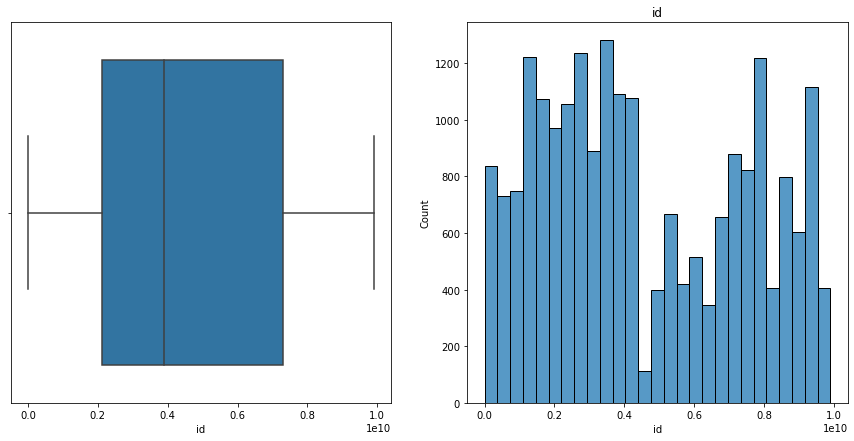

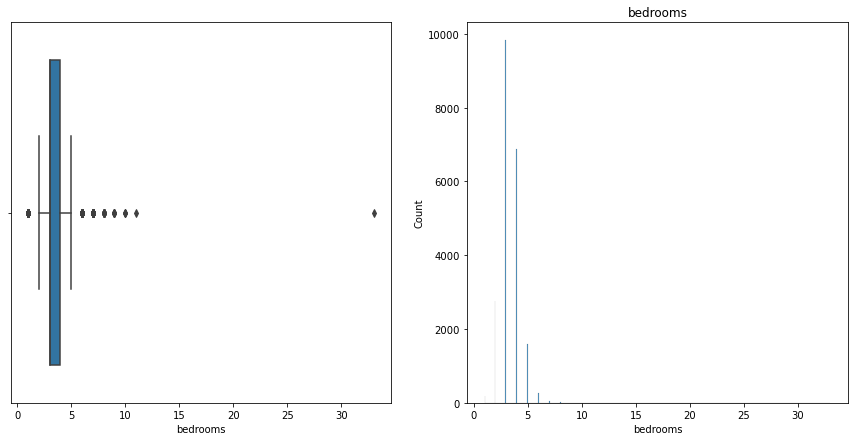

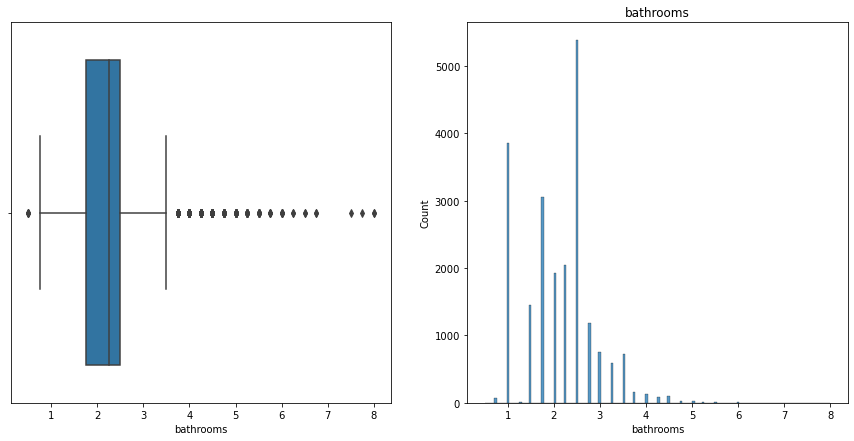

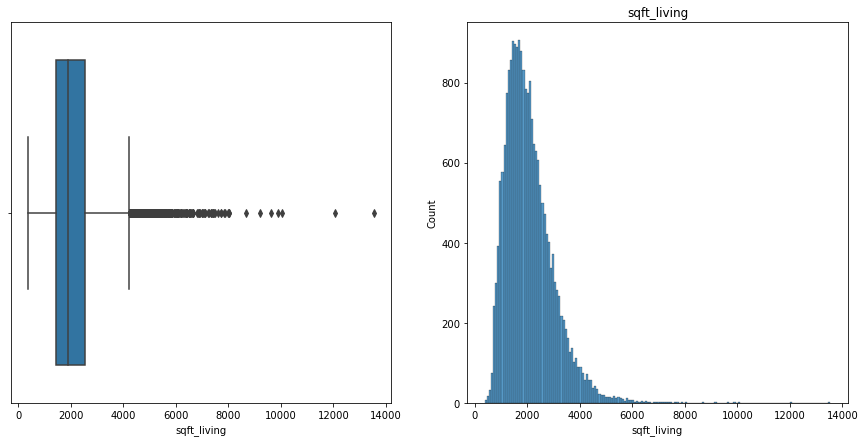

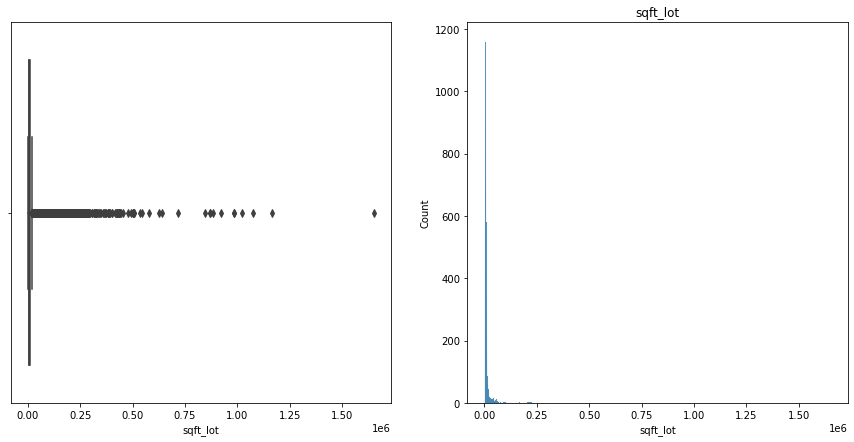

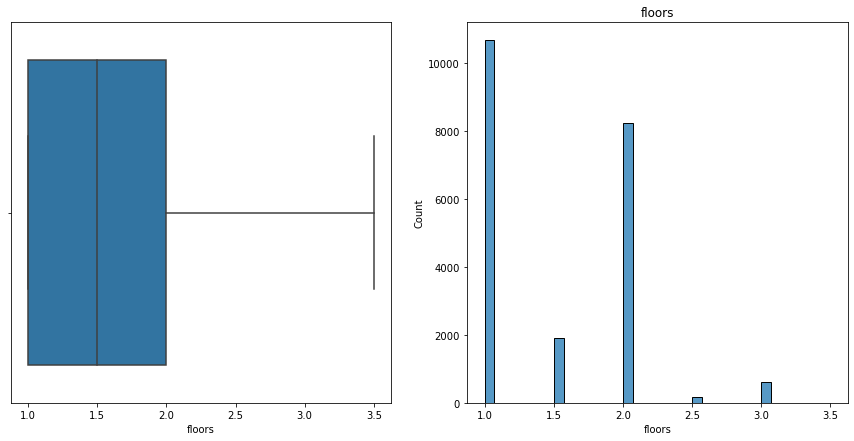

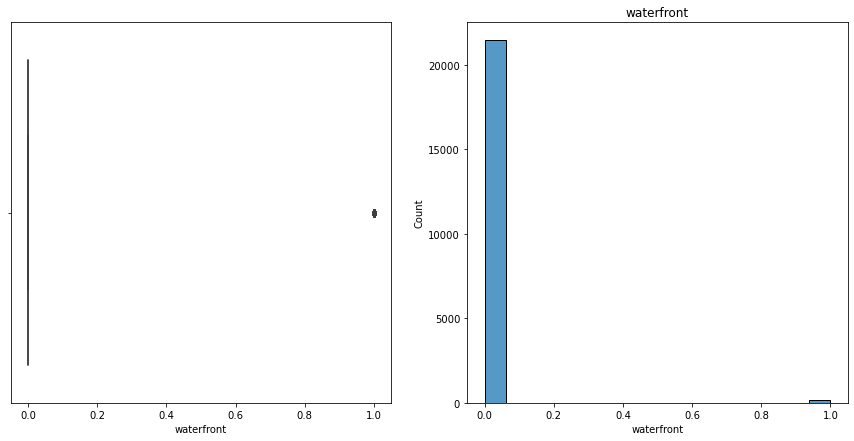

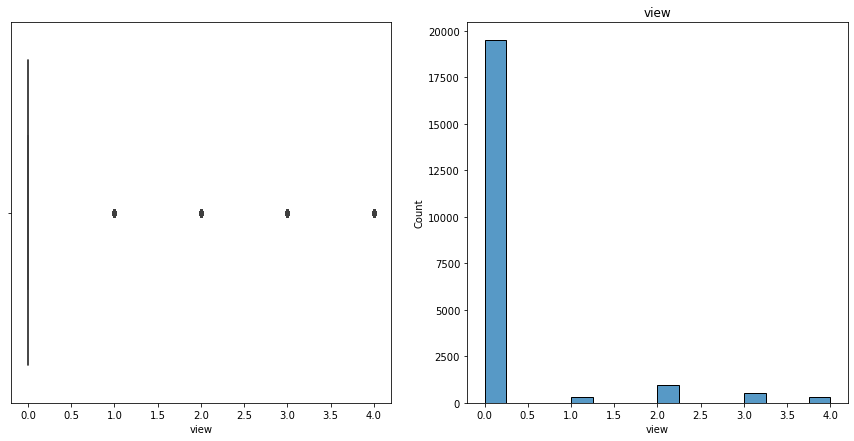

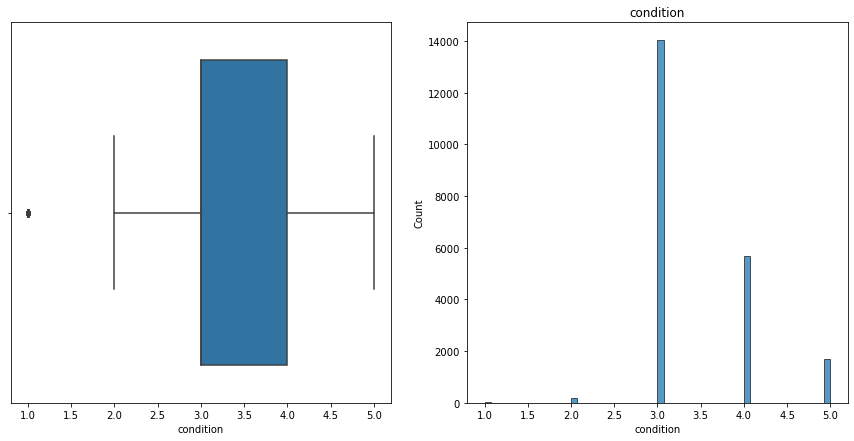

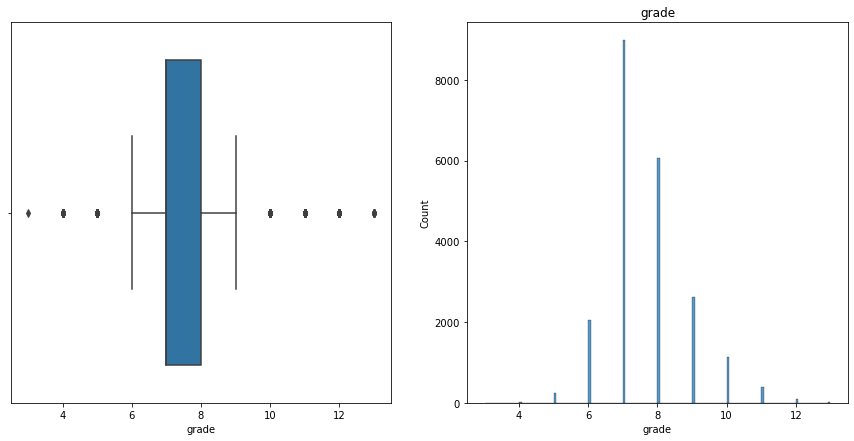

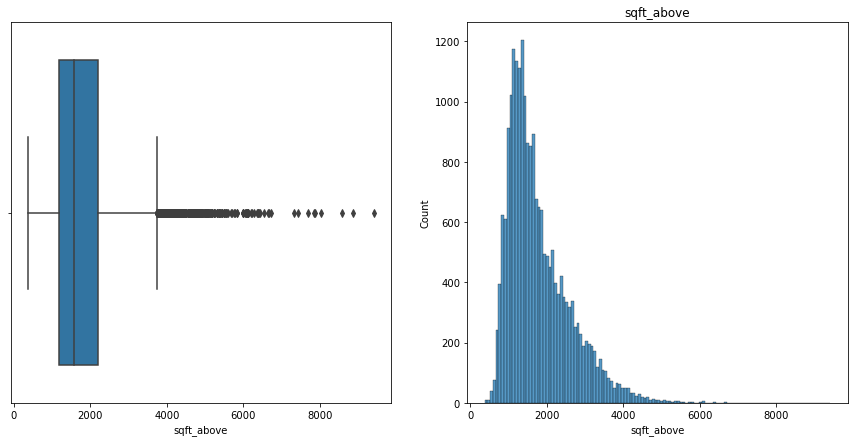

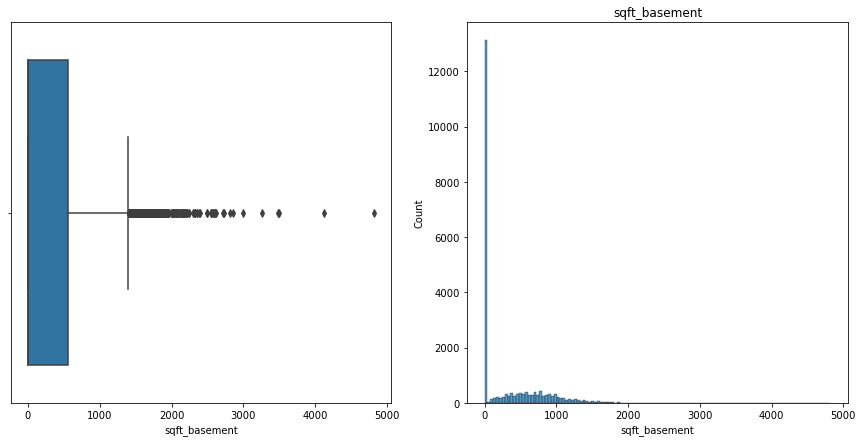

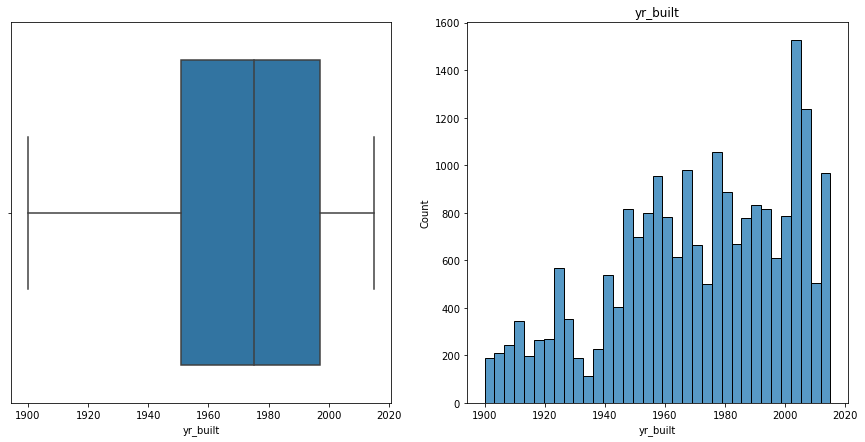

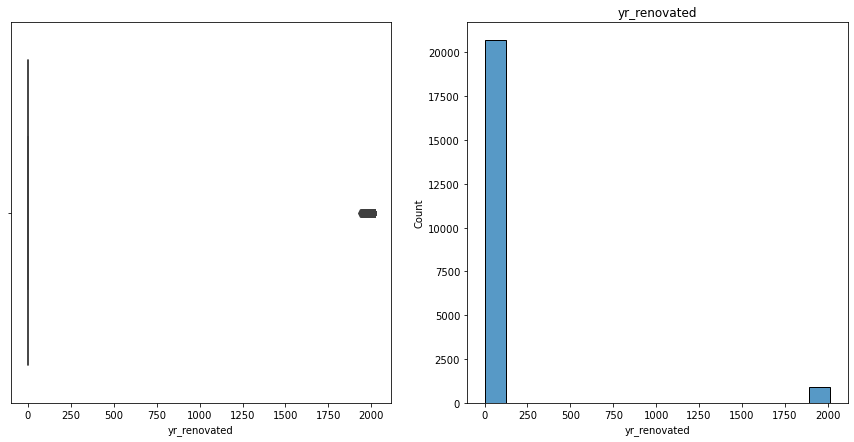

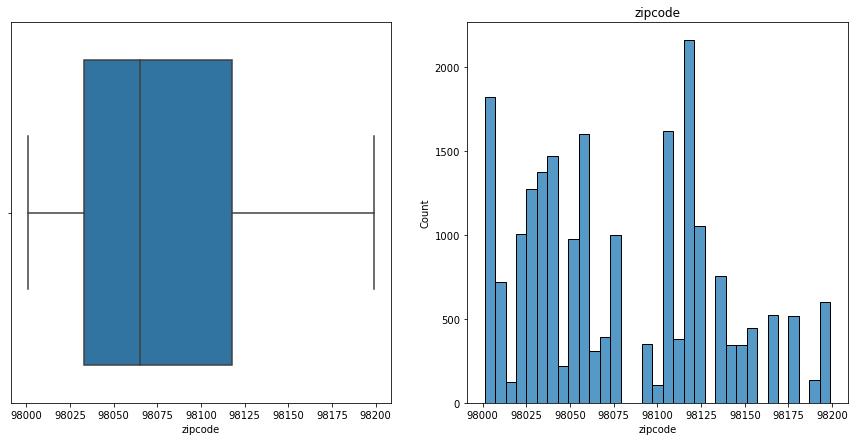

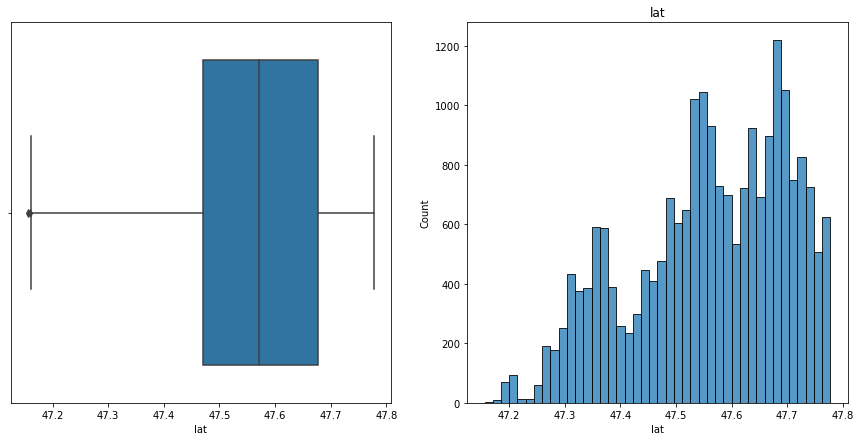

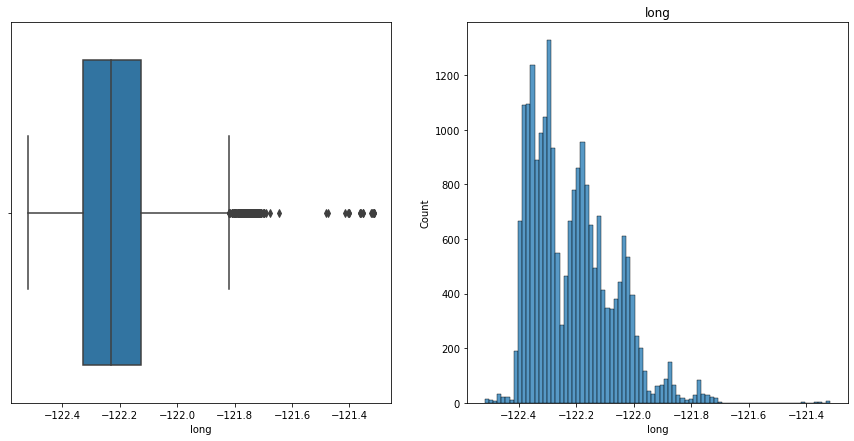

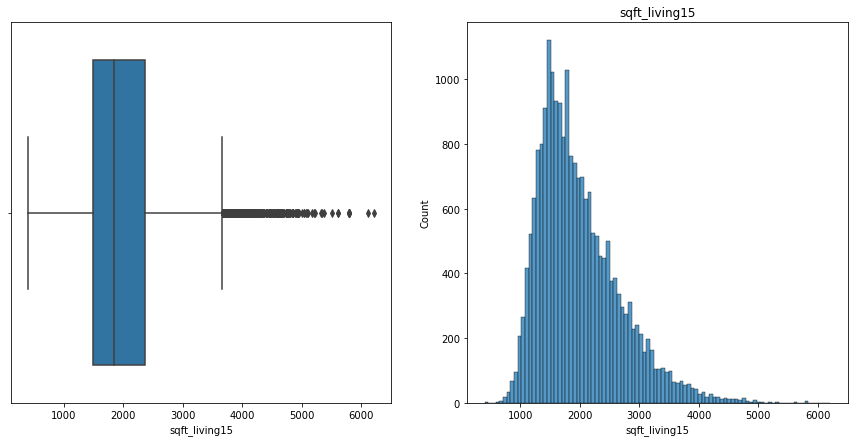

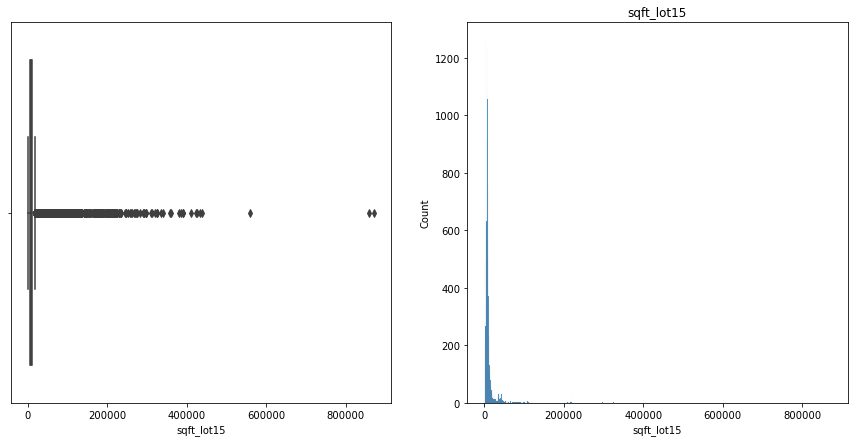

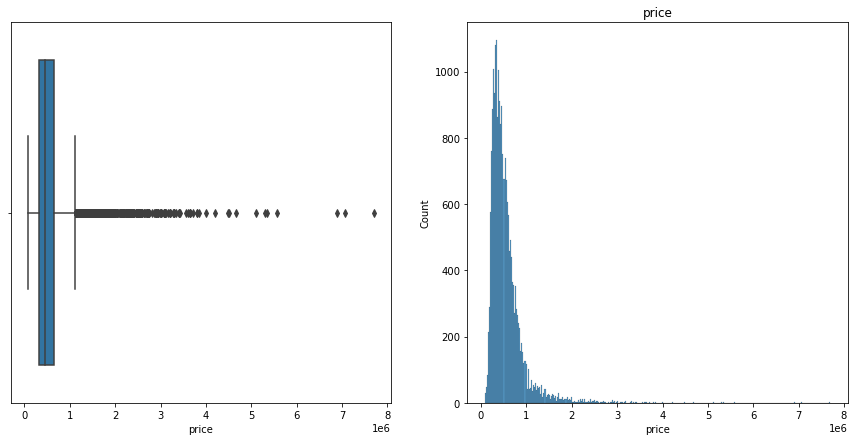

In [130]:
# analyze raw data
plot_numeric(raw_data)


#### 3.2 Heatmap
<a id='heatmap'></a>
<a href='#content'>back to content list</a>

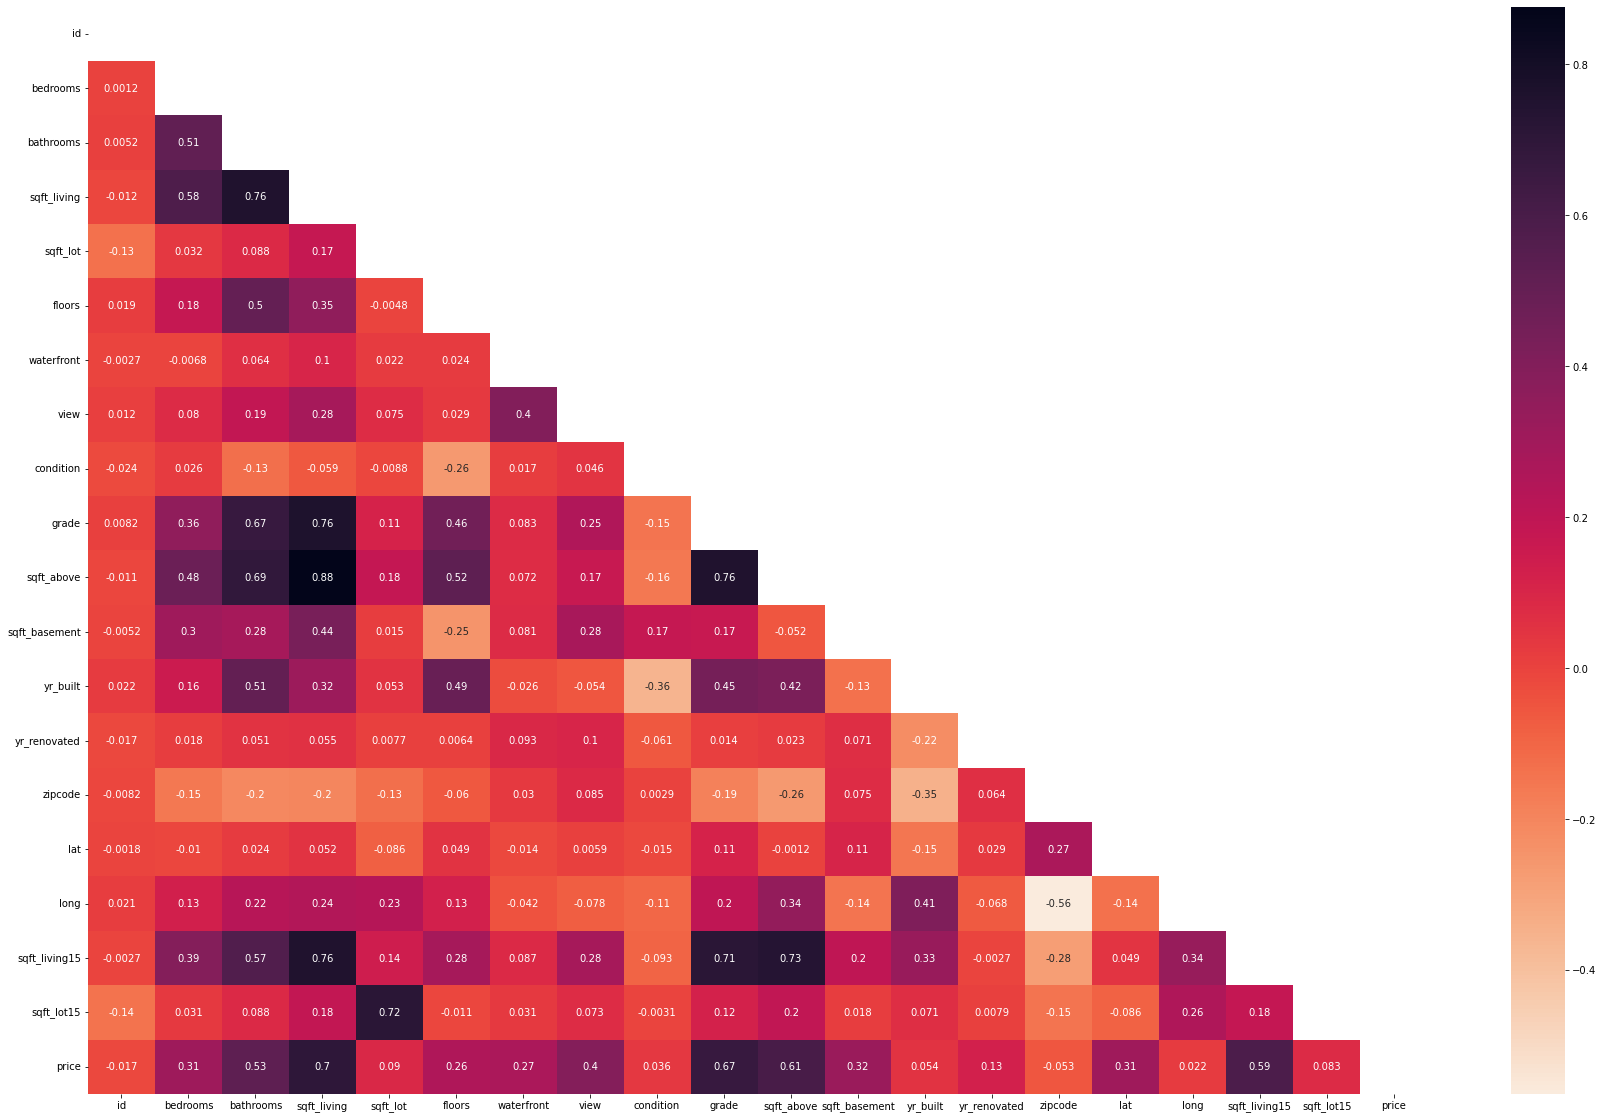

In [131]:
cmap = sns.cm.rocket_r  ## for reversing the colors
mask=np.zeros_like(raw_data._get_numeric_data().corr())
mask[np.triu_indices_from(mask)]=True
fig, ax=plt.subplots(figsize=(30, 20))
ax=sns.heatmap(raw_data._get_numeric_data().corr(), mask=mask, annot=True,cmap=cmap)
plt.show()

#### **3.3 Discussion raw data:** 
<a id='analyze_raw_data'></a>
<a href='#content'>back to content list</a>

> Possible changes:
>
> id -> will be removed as not mandatory
>
> bedrooms -> need adjustments as max 33 could be an outlayer, without -> normal distributed
>
> bathrooms -> max 8 needs to check, if its fits with connected sqft range ->
>
> sqft_living -> maybe recalculated in square meter to fit better in european perspective
>
> sqft_lot -> similar to sqft_living
>
> floors -> maybe changable to ordonal categorical
>
> waterfront -> set to categorical 
>
> view -> needs review why min to 75% is zero with an max of 4
>
> condition -> transform to ordonal categorical 0-5
>
> grade -> as descripted typical ordonal categorical 0-13
>
> sqft_above -> similar to sqft_living
>
> sqft_basement -> similar to sqft_living
> - as sqft_basement looks without zero numbers as normal distributed
> - ***ToDo:*** drop zero values from this column
> - create category 'has_basement'
> - fill all 'has_basement' where basement is included
>
> yr_build -> use as number or could be ordonal category when binning with steps e.g 5 years 1900-1905 ....
>
> zip code, lat and long -> skipt or could binning or clustered to regions 
>
> sqft_living15 and sqft_lot15 represents the average living and lot sqft of the closest 15 neiboorhouses





<a id='modeling'></a>
### Modelling

<a id='version_1'></a>
### Version 1
<a href='#content'>back to content list</a>


This example using nearly the whole data set to get a first impression.

Only ID and Date will dropped as ID holds no usefull information

The Date can not used without further transformation

In [132]:
# drop first not need data
work_copy_v1= raw_data.copy()

work_copy_v1.drop(columns=['id', 'date'], inplace=True)


In [133]:
# drop label or dependent value for ML
label_v1 = work_copy_v1['price']
work_copy_v1.drop(columns='price', inplace=True)


In [134]:
# split dataset in 80% training data and hold 20% for evaluating the results

x_train_v1, x_test_v1, y_train_v1, y_test_v1 = train_test_split(work_copy_v1, label_v1, test_size=0.2, random_state=42)

In [135]:
# apply standart scale on train and test data
# Note: the function behind will fit the scaler only with the training data, but apply the resulting scaler in both sets

x_train_v1, x_test_v1 = apply_standart_scaler(x_train_data=x_train_v1, x_test_data=x_test_v1)

In [136]:
# linear model with sklearn 

model_v1 = create_linear_model(x_train=x_train_v1, y_train=y_train_v1)

In [137]:
# just a handy plot to check internal values

create_linear_model_statsmodel_analyze(x_train_v1, y_train_v1)

/opt/anaconda3/envs/DA_Enviroment/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.702
Model:                            OLS   Adj. R-squared:                  0.702
Method:                 Least Squares   F-statistic:                     2392.
Date:                Fri, 19 Nov 2021   Prob (F-statistic):               0.00
Time:                        16:08:11   Log-Likelihood:            -2.3552e+05
No. Observations:               17277   AIC:                         4.711e+05
Df Residuals:                   17259   BIC:                         4.712e+05
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const          6.188e+06   3.28e+06      1.884      0.060   -2.49e+05    1.26e+07
bedrooms      -3.835e+04   2212.127    -17.335      0.000   -4.27e+04    -3.4e+04
bathrooms      4.213e+04   3681.555     11.442      0.000    3.49e+04    4.93e+04
sqft_living     110.6321      2.581     42.869      0.000     105.574     115.691
sqft_lot          0.1037      0.055      1.898      0.058      -0.003       0.211
floors         8383.0996   4031.878      2.079      0.038     480.210    1.63e+04
waterfront     5.789e+05   1.93e+04     29.926      0.000    5.41e+05    6.17e+05
view           5.172e+04   2399.625     21.552      0.000     4.7e+04    5.64e+04
condition      2.863e+04   2633.790     10.870      0.000    2.35e+04    3.38e+04
grade          9.871e+04   2419.834     40.794      0.000     9.4e+04    1.03e+05
sqft_above       69.0376      2.542     27.154      0.000      64.054      74.021
sqft_basement    41.5972      2.976     13.978      0.000      35.764      47.430
yr_built      -2683.4602     81.391    -32.970      0.000   -2842.994   -2523.926
yr_renovated     19.5500      4.106      4.761      0.000      11.502      27.598
zipcode        -562.6960     36.930    -15.237      0.000    -635.082    -490.310
lat              5.9e+05    1.2e+04     48.963      0.000    5.66e+05    6.14e+05
long          -2.088e+05   1.46e+04    -14.276      0.000   -2.37e+05    -1.8e+05
sqft_living15    24.6215      3.890      6.330      0.000      16.997      32.246
sqft_lot15       -0.4517      0.082     -5.515      0.000      -0.612      -0.291
==============================================================================
Omnibus:                    14778.856   Durbin-Watson:                   1.994
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1466590.026
Skew:                           3.606   Prob(JB):                         0.00
Kurtosis:                      47.557   Cond. No.                     1.18e+17
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 1.25e-20. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [138]:
# create predictions

y_pred_train_v1 = model_v1.predict(x_train_v1)
y_pred_test_v1 = model_v1.predict(x_test_v1)

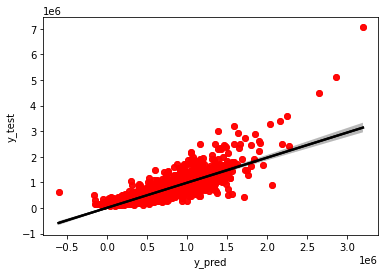

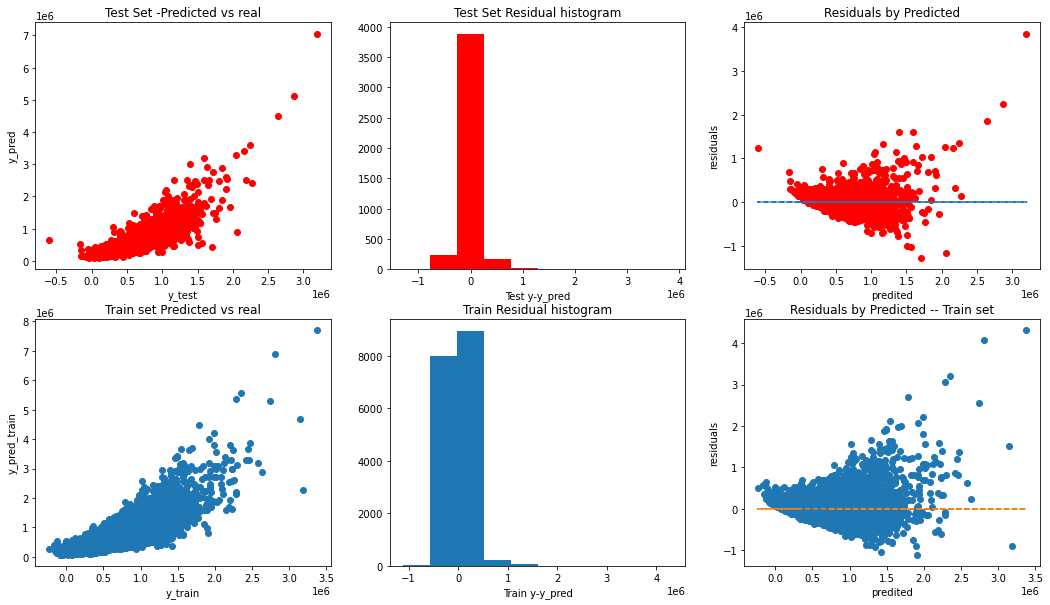

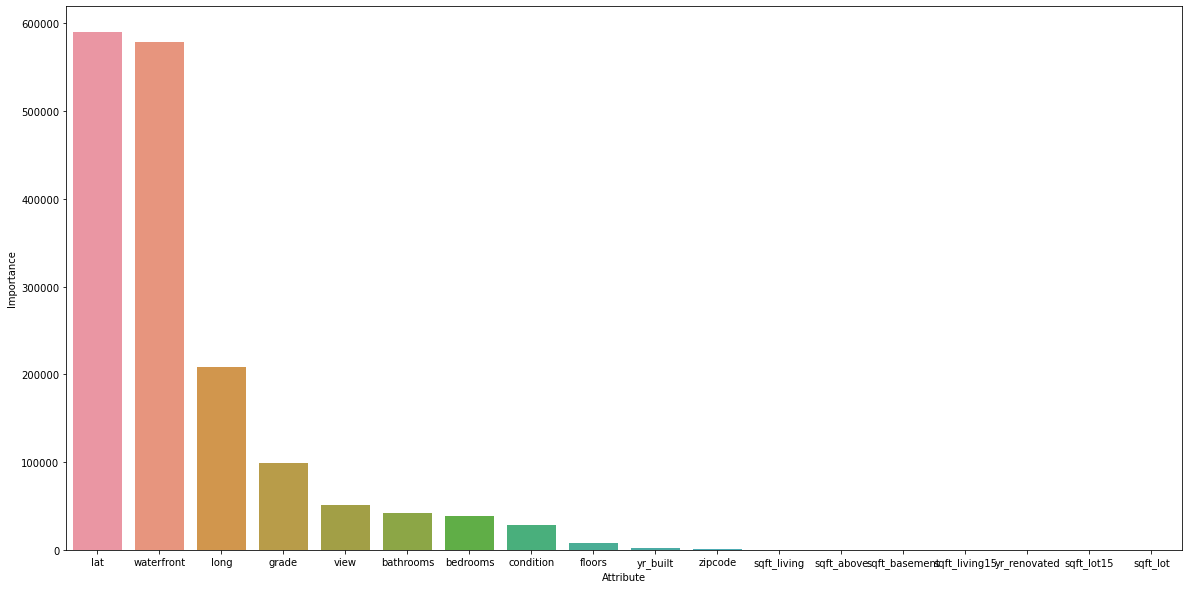

Most important features:
        Attribute     Importance
14            lat  589969.594598
5      waterfront  578940.273893
15           long  208788.216055
18          grade   98713.513694
6            view   51717.326838
23      bathrooms   42125.942503
22       bedrooms   38346.695094
21      condition   28629.833696
20         floors    8383.099561
11       yr_built    2683.460201
19        zipcode     562.695970
2     sqft_living     110.632992
9      sqft_above      69.036713
10  sqft_basement      41.596279
16  sqft_living15      24.621516
12   yr_renovated      19.550010
17     sqft_lot15       0.451728
3        sqft_lot       0.103737
train MSE: 40562876545.17649 -- test MSE: 40182718832.85667
train RMSE: 201402.27542204305 -- test RMSE: 200456.27661127667
train MAE: 40562876545.17649 -- test MAE: 40182718832.85667
r2 train: 0.7020284717016776
r2 test: 0.6914155526646741


In [139]:
# validate results

validate_results(model_v1, x_train_v1, y_train_v1, y_test_v1, y_pred_train_v1, y_pred_test_v1)

### Discussion

First run with an R2 of nearly 0.7 shows that waterfront, grade and location informations are high predictors for this model

- next improvements is clearly review datatypes in terms of outlayers and distribution


<a id='version_2'></a>
### Version 2

[back to content](#content)

In [140]:
# create work copy and drop first not need data
work_copy_v2= raw_data.copy()

work_copy_v2.drop(columns=['id', 'date', 'sqft_above'], inplace=True)

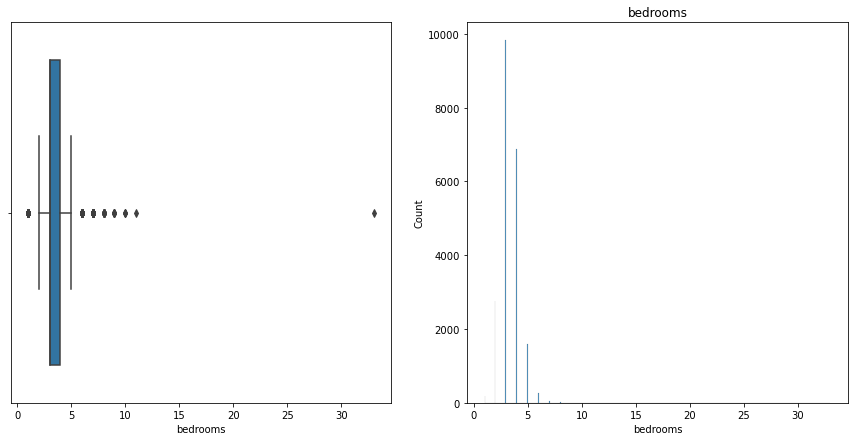

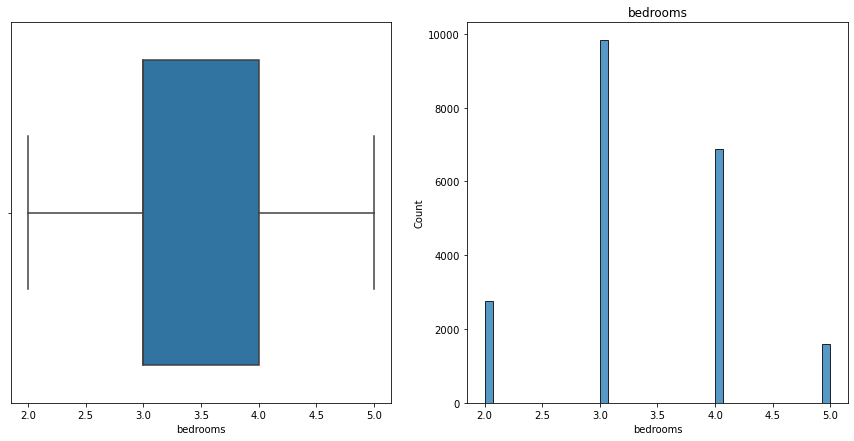

In [141]:
# bedrooms
plot_numeric_part(work_copy_v2, 'bedrooms')
# 33 bedrooms is marked as outlayer and distribution looks like left shifted
# first try aggregate interquartile function

work_copy_v2 = reduce_to_interquartile(work_copy_v2, 'bedrooms')
plot_numeric_part(work_copy_v2, 'bedrooms')

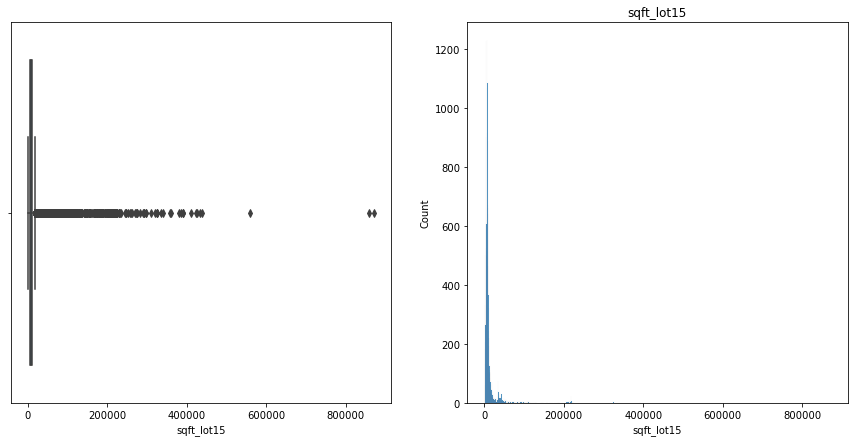

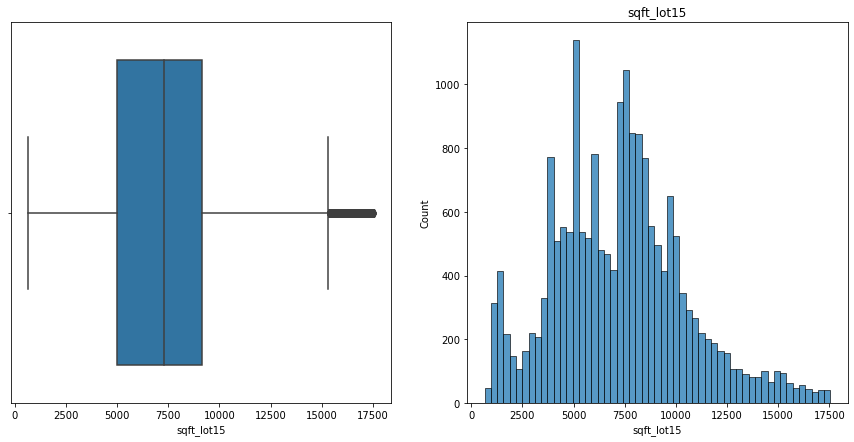

In [142]:
plot_numeric_part(work_copy_v2, 'sqft_lot15')
work_copy_v2 = reduce_to_interquartile(data=work_copy_v2, name='sqft_lot15')
plot_numeric_part(work_copy_v2, 'sqft_lot15')

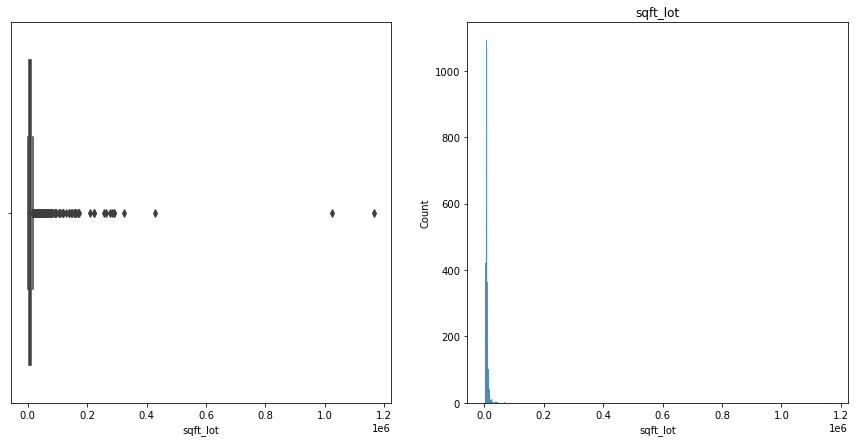

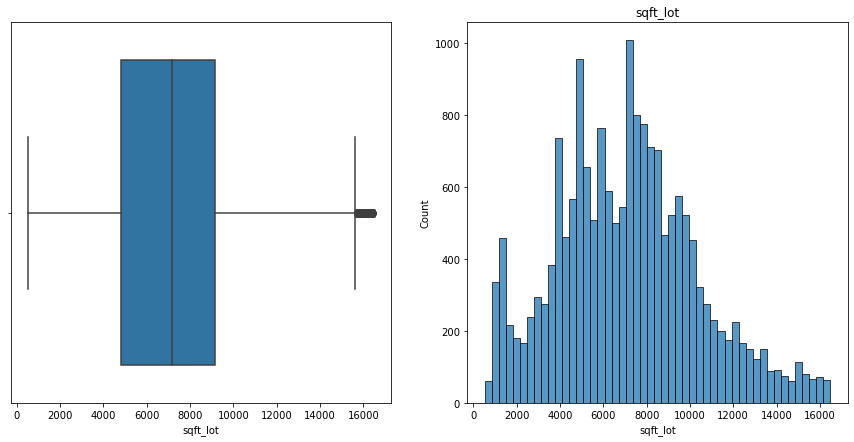

In [143]:
plot_numeric_part(work_copy_v2, 'sqft_lot')
work_copy_v2 = reduce_to_interquartile(data=work_copy_v2, name='sqft_lot')
plot_numeric_part(work_copy_v2, 'sqft_lot')

In [144]:
label_v2 = work_copy_v2['price']
work_copy_v2.drop(columns='price', inplace=True)

In [145]:
x_train_v2, x_test_v2, y_train_v2, y_test_v2 = train_test_split(work_copy_v2, label_v2, test_size= 0.20, random_state= 42)

In [146]:
x_train_v2, x_test_v2 = apply_standart_scaler(x_train_v2, x_test_v2)
model_v2 = create_linear_model(x_train=x_train_v2, y_train=y_train_v2)
y_pred_train_v2 = model_v2.predict(x_train_v2)
y_pred_test_v2 = model_v2.predict(x_test_v2)

In [147]:
create_linear_model_statsmodel_analyze(x_train_v2, y_train_v2)

/opt/anaconda3/envs/DA_Enviroment/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.712
Model:                            OLS   Adj. R-squared:                  0.712
Method:                 Least Squares   F-statistic:                     2114.
Date:                Fri, 19 Nov 2021   Prob (F-statistic):               0.00
Time:                        16:08:35   Log-Likelihood:            -1.9499e+05
No. Observations:               14528   AIC:                         3.900e+05
Df Residuals:                   14510   BIC:                         3.902e+05
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const          3.817e+06   2.94e+06      1.299      0.194   -1.94e+06    9.58e+06
bedrooms      -3.017e+04   2219.184    -13.594      0.000   -3.45e+04   -2.58e+04
bathrooms      3.449e+04   3370.628     10.232      0.000    2.79e+04    4.11e+04
sqft_living     159.5564      4.198     38.012      0.000     151.329     167.784
sqft_lot         -4.8501      0.921     -5.267      0.000      -6.655      -3.045
floors          518.7139   4040.881      0.128      0.898   -7401.928    8439.356
waterfront     6.774e+05   2.44e+04     27.798      0.000     6.3e+05    7.25e+05
view           4.919e+04   2307.649     21.315      0.000    4.47e+04    5.37e+04
condition      2.758e+04   2363.366     11.668      0.000    2.29e+04    3.22e+04
grade          1.045e+05   2254.479     46.366      0.000       1e+05    1.09e+05
sqft_basement   -23.1507      4.807     -4.816      0.000     -32.573     -13.728
yr_built      -2513.5563     72.053    -34.885      0.000   -2654.789   -2372.323
yr_renovated     14.1447      3.795      3.727      0.000       6.706      21.584
zipcode        -446.3106     32.833    -13.594      0.000    -510.667    -381.955
lat            5.842e+05   1.09e+04     53.682      0.000    5.63e+05    6.06e+05
long          -1.346e+05   1.39e+04     -9.664      0.000   -1.62e+05   -1.07e+05
sqft_living15    21.3247      3.807      5.601      0.000      13.862      28.787
sqft_lot15       -1.1679      0.983     -1.188      0.235      -3.094       0.758
==============================================================================
Omnibus:                     7789.430   Durbin-Watson:                   1.997
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           146899.991
Skew:                           2.159   Prob(JB):                         0.00
Kurtosis:                      17.967   Cond. No.                     2.14e+08
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.14e+08. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

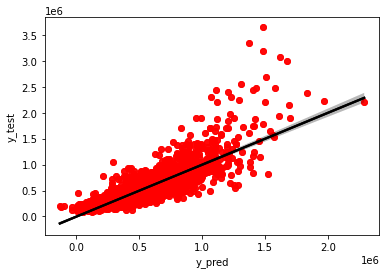

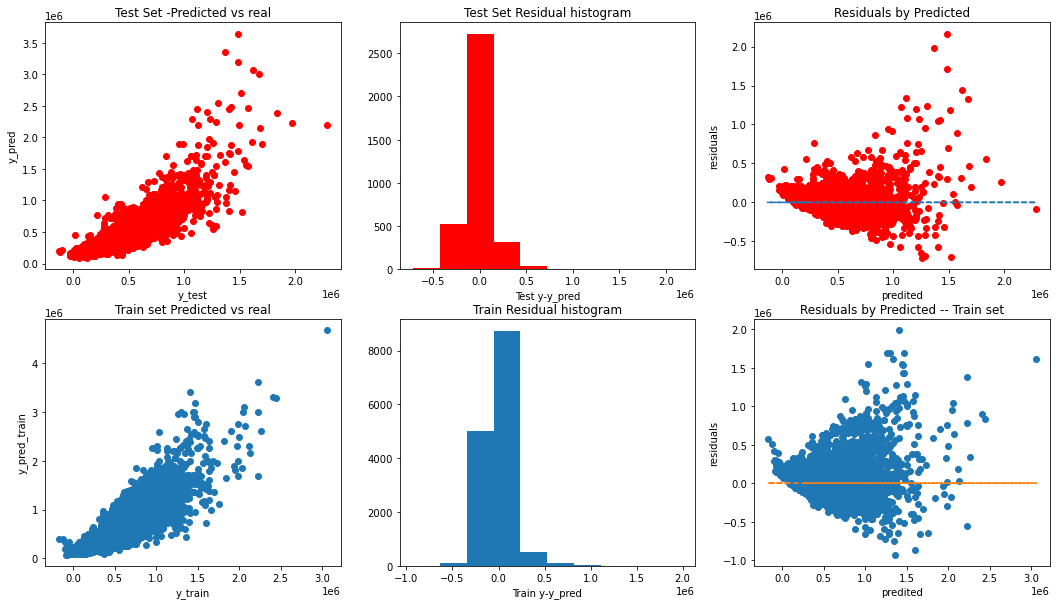

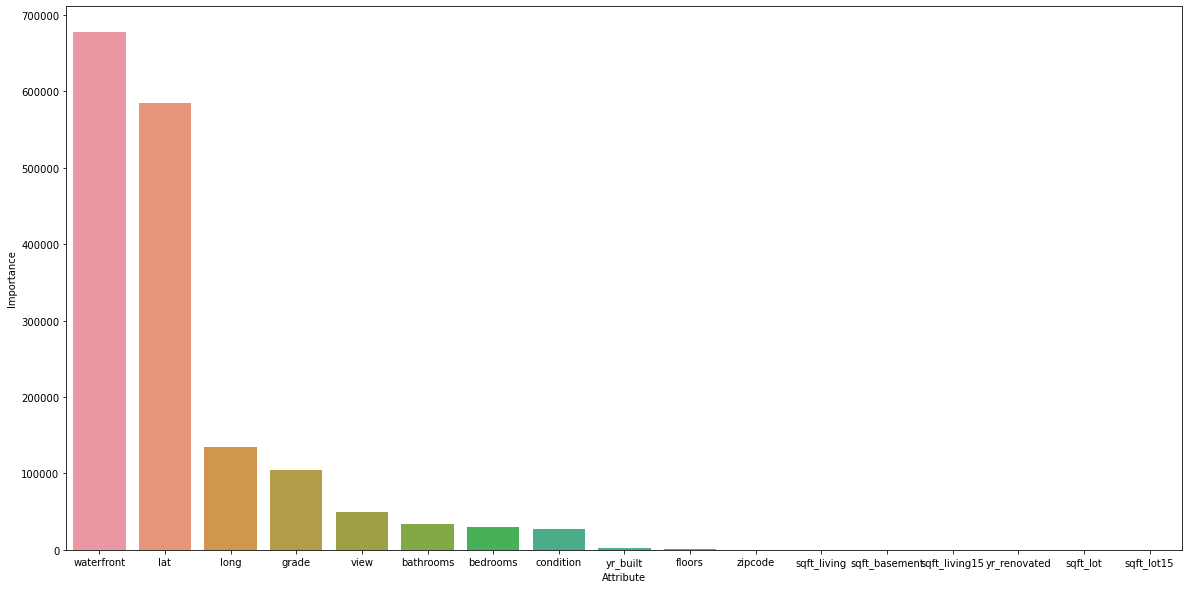

Most important features:
        Attribute     Importance
5      waterfront  677447.843389
13            lat  584245.808552
14           long  134646.915834
17          grade  104530.636996
6            view   49187.100152
22      bathrooms   34487.941722
21       bedrooms   30167.090347
20      condition   27576.541223
10       yr_built    2513.556276
19         floors     518.713936
18        zipcode     446.310611
2     sqft_living     159.556445
9   sqft_basement      23.150655
15  sqft_living15      21.324734
11   yr_renovated      14.144728
3        sqft_lot       4.850111
16     sqft_lot15       1.167950
train MSE: 26645258132.880657 -- test MSE: 29121482063.22147
train RMSE: 163233.75304415644 -- test RMSE: 170650.174518579
train MAE: 26645258132.880657 -- test MAE: 29121482063.22147
r2 train: 0.7123406989062631
r2 test: 0.6864164802677766


In [148]:
validate_results(model_v2, x_train_v2, y_train_v2,y_test_v2,y_pred_train_v2, y_pred_test_v2)

#### Discussion


<a id='version_3'></a>
### Version 3 
[back to content list](#content)

In [149]:
# create work copy and drop first not need data
work_copy_v3= raw_data.copy()

work_copy_v3.drop(columns=['id', 'date'], inplace=True)

In [150]:
work_copy_v3 = reduce_to_interquartile(data=work_copy_v3, name='bedrooms')
work_copy_v3 = reduce_to_interquartile(data=work_copy_v3, name='sqft_lot')

In [151]:
# making sqft_basement and yr_renovated as binary category

work_copy_v3['sqft_basement'].values[work_copy_v3['sqft_basement'] != 0] = 1
work_copy_v3['yr_renovated'].values[work_copy_v3['yr_renovated'] != 0] = 1

In [152]:
# apply transformation

In [153]:
label_v3 = work_copy_v3['price']
work_copy_v3.drop(columns='price', inplace=True)

In [154]:
x_train_v3, x_test_v3, y_train_v3, y_test_v3 = train_test_split(work_copy_v3, label_v3, test_size= 0.20, random_state= 42)

In [155]:
x_train_v3, x_test_v3 = apply_standart_scaler(x_train_v3, x_test_v3)
model_v3 = create_linear_model(x_train=x_train_v3, y_train=y_train_v3)
y_pred_train_v3 = model_v3.predict(x_train_v3)
y_pred_test_v3 = model_v3.predict(x_test_v3)

In [156]:
create_linear_model_statsmodel_analyze(x_train_v3, y_train_v3)

/opt/anaconda3/envs/DA_Enviroment/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.711
Model:                            OLS   Adj. R-squared:                  0.711
Method:                 Least Squares   F-statistic:                     2044.
Date:                Fri, 19 Nov 2021   Prob (F-statistic):               0.00
Time:                        16:08:38   Log-Likelihood:            -2.0147e+05
No. Observations:               14967   AIC:                         4.030e+05
Df Residuals:                   14948   BIC:                         4.031e+05
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const          8.645e+06   3.01e+06      2.874      0.004    2.75e+06    1.45e+07
bedrooms      -3.209e+04   2264.674    -14.172      0.000   -3.65e+04   -2.77e+04
bathrooms      3.689e+04   3496.736     10.550      0.000       3e+04    4.37e+04
sqft_living     143.1936      6.835     20.951      0.000     129.797     156.591
sqft_lot         -4.7844      0.612     -7.821      0.000      -5.983      -3.585
floors         1035.7398   4066.319      0.255      0.799   -6934.745    9006.225
waterfront     6.031e+05   2.21e+04     27.260      0.000     5.6e+05    6.46e+05
view           5.761e+04   2341.757     24.602      0.000     5.3e+04    6.22e+04
condition      2.904e+04   2421.278     11.994      0.000    2.43e+04    3.38e+04
grade          1.019e+05   2299.166     44.319      0.000    9.74e+04    1.06e+05
sqft_above       14.4562      7.534      1.919      0.055      -0.312      29.224
sqft_basement -5550.4664   5455.667     -1.017      0.309   -1.62e+04    5143.310
yr_built      -2520.3782     73.928    -34.092      0.000   -2665.286   -2375.470
yr_renovated   3.715e+04   7731.070      4.805      0.000     2.2e+04    5.23e+04
zipcode        -512.4414     33.473    -15.309      0.000    -578.052    -446.831
lat            5.782e+05   1.11e+04     52.103      0.000    5.56e+05       6e+05
long          -1.507e+05   1.43e+04    -10.556      0.000   -1.79e+05   -1.23e+05
sqft_living15    31.1099      3.826      8.131      0.000      23.611      38.609
sqft_lot15       -0.5687      0.441     -1.290      0.197      -1.433       0.295
==============================================================================
Omnibus:                     8368.371   Durbin-Watson:                   2.009
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           178111.222
Skew:                           2.248   Prob(JB):                         0.00
Kurtosis:                      19.291   Cond. No.                     2.14e+08
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.14e+08. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

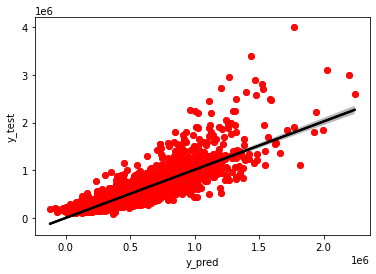

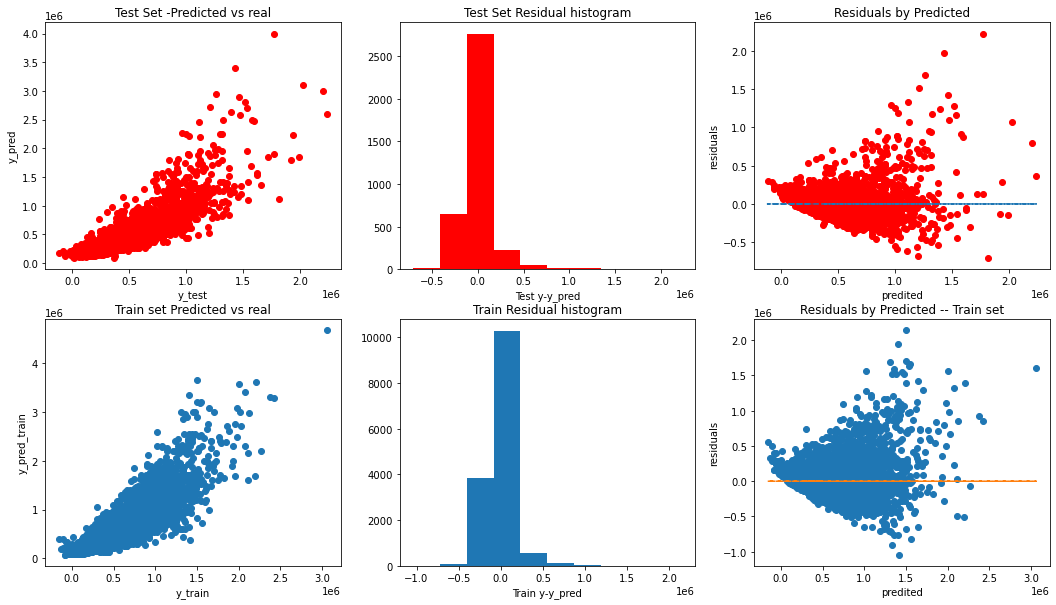

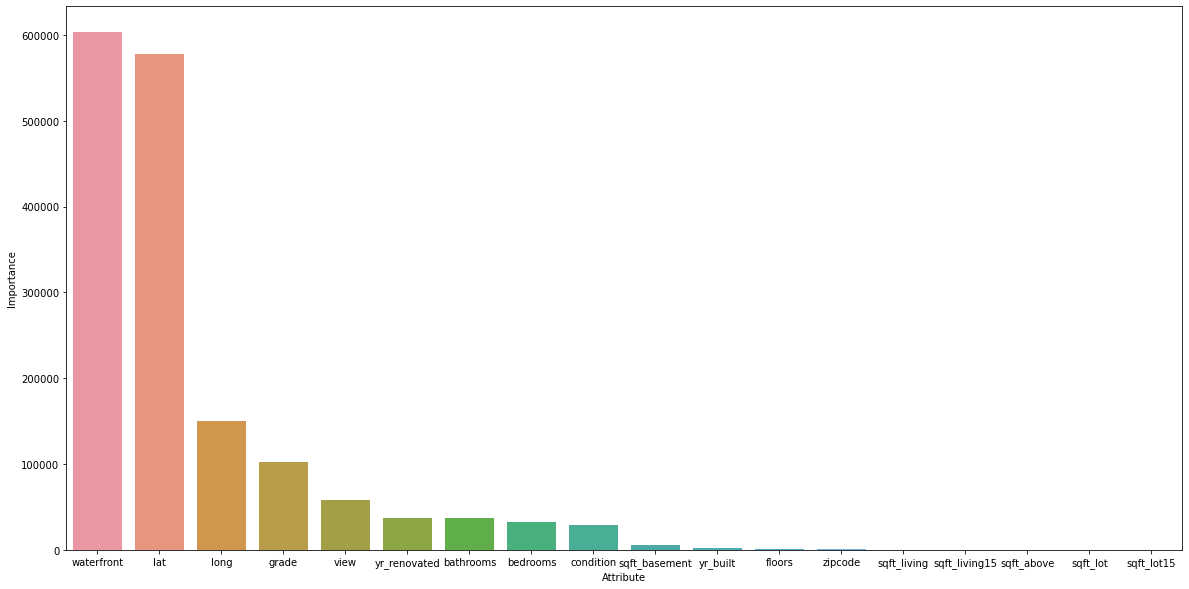

Most important features:
        Attribute     Importance
5      waterfront  603057.677992
14            lat  578150.522703
15           long  150650.900882
18          grade  101897.741354
6            view   57611.760921
12   yr_renovated   37147.572230
23      bathrooms   36891.247092
22       bedrooms   32094.678426
21      condition   29039.844801
10  sqft_basement    5550.466425
11       yr_built    2520.378190
20         floors    1035.739834
19        zipcode     512.441370
2     sqft_living     143.193625
16  sqft_living15      31.109940
9      sqft_above      14.456154
3        sqft_lot       4.784351
17     sqft_lot15       0.568659
train MSE: 28825955178.46729 -- test MSE: 34010959525.047157
train RMSE: 169782.0814410852 -- test RMSE: 184420.6049362358
train MAE: 28825955178.46729 -- test MAE: 34010959525.047157
r2 train: 0.7110829624136237
r2 test: 0.6861223594090406


In [157]:
validate_results(model_v3, x_train_v3, y_train_v3,y_test_v3,y_pred_train_v3, y_pred_test_v3)

<a id='version_4'></a>
### Version 4 
[back to content list](#content)

In [173]:
#raw_data

In [159]:
work_copy_v4 = raw_data.copy()

In [160]:
# droping long and lat coordinates, as this location information is allready included in the zipcodes
work_copy_v4.drop(columns=['id', 'date', 'long', 'lat', 'sqft_above'], inplace=True)

# sqft_above

In [161]:
# interquartile sqft_living
work_copy_v4 =  work_copy_v4[work_copy_v4['bedrooms'] != 33]
work_copy_v4 = reduce_to_interquartile(data=work_copy_v4, name='bedrooms')


work_copy_v4 = reduce_to_interquartile(data=work_copy_v4, name='sqft_lot')

In [162]:

transpower = PowerTransformer(method='box-cox')
transpower_norm = QuantileTransformer()

work_copy_v4['price'] = transpower.fit_transform(work_copy_v4['price'].to_numpy().reshape(-1,1))

work_copy_v4['sqft_living'] = transpower.fit_transform(work_copy_v4['sqft_living'].to_numpy().reshape(-1,1))
work_copy_v4['sqft_lot'] = transpower.fit_transform(work_copy_v4['sqft_lot'].to_numpy().reshape(-1,1))
work_copy_v4['sqft_living15'] = transpower.fit_transform(work_copy_v4['sqft_living15'].to_numpy().reshape(-1,1))

work_copy_v4['sqft_lot15'] = transpower_norm.fit_transform(work_copy_v4['sqft_lot15'].to_numpy().reshape(-1,1))
work_copy_v4['yr_built'] = transpower_norm.fit_transform(work_copy_v4['yr_built'].to_numpy().reshape(-1,1))

In [163]:
# basement has no real influence so i transform this to an binary has or has not field 0 or 1
work_copy_v4['sqft_basement'].values[work_copy_v4['sqft_basement'] != 0] = 1
work_copy_v4['yr_renovated'].values[work_copy_v4['yr_renovated'] != 0] = 1


# test with quantil tranformation -> seems not realy an improvement
#work_copy_v4['sqft_basement'] = transpower_norm.fit_transform(work_copy_v4['sqft_basement'].to_numpy().reshape(-1,1))
#work_copy_v4['yr_renovated'] = transpower_norm.fit_transform(work_copy_v4['yr_renovated'].to_numpy().reshape(-1,1))

In [164]:
work_copy_v4 = create_dummies_for_categorie(work_copy_v4, 'zipcode')
work_copy_v4 = create_dummies_for_categorie(work_copy_v4, 'grade')
work_copy_v4 = create_dummies_for_categorie(work_copy_v4, 'floors')
work_copy_v4 = create_dummies_for_categorie(work_copy_v4, 'bedrooms')
work_copy_v4 = create_dummies_for_categorie(work_copy_v4, 'condition')
work_copy_v4 = create_dummies_for_categorie(work_copy_v4, 'bathrooms')

In [165]:
label_v4 = work_copy_v4['price']
work_copy_v4.drop(columns='price', inplace=True)

In [166]:
x_train_v4, x_test_v4, y_train_v4, y_test_v4 = train_test_split(work_copy_v4, label_v4, test_size= 0.20, random_state= 42)

In [167]:
x_train_v4, x_test_v4 = apply_standart_scaler(x_train_v4, x_test_v4)

In [168]:
model_v4 = create_linear_model(x_train=x_train_v4, y_train=y_train_v4)

In [169]:
y_pred_train_v4 = model_v4.predict(x_train_v4)
y_pred_test_v4 = model_v4.predict(x_test_v4)

In [170]:
create_linear_model_statsmodel_analyze(x_train_v4, y_train_v4)

/opt/anaconda3/envs/DA_Enviroment/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.876
Model:                            OLS   Adj. R-squared:                  0.875
Method:                 Least Squares   F-statistic:                     876.4
Date:                Fri, 19 Nov 2021   Prob (F-statistic):               0.00
Time:                        16:08:42   Log-Likelihood:                -5555.4
No. Observations:               14967   AIC:                         1.135e+04
Df Residuals:                   14846   BIC:                         1.227e+04
Df Model:                         120                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const             -2.9324      0.266    -11.022      0.000      -3.454      -2.411
sqft_living        0.3295      0.007     47.279      0.000       0.316       0.343
sqft_lot           0.0605      0.007      8.851      0.000       0.047       0.074
waterfront         0.8702      0.047     18.466      0.000       0.778       0.963
view               0.1090      0.005     22.023      0.000       0.099       0.119
sqft_basement     -0.0833      0.008    -10.318      0.000      -0.099      -0.067
yr_built          -0.0005      0.021     -0.022      0.983      -0.042       0.041
yr_renovated       0.1429      0.016      8.698      0.000       0.111       0.175
sqft_living15      0.1080      0.005     21.501      0.000       0.098       0.118
sqft_lot15        -0.1131      0.024     -4.779      0.000      -0.159      -0.067
zipcode_98002      0.0246      0.038      0.653      0.514      -0.049       0.098
zipcode_98003      0.0971      0.034      2.885      0.004       0.031       0.163
zipcode_98004      2.1967      0.035     63.582      0.000       2.129       2.264
zipcode_98005      1.5990      0.043     36.967      0.000       1.514       1.684
zipcode_98006      1.3554      0.031     44.061      0.000       1.295       1.416
zipcode_98007      1.3882      0.042     33.262      0.000       1.306       1.470
zipcode_98008      1.4224      0.033     42.493      0.000       1.357       1.488
zipcode_98010      0.5316      0.062      8.591      0.000       0.410       0.653
zipcode_98011      1.0198      0.037     27.591      0.000       0.947       1.092
zipcode_98014      0.6699      0.064     10.460      0.000       0.544       0.795
zipcode_98019      0.7505      0.040     18.697      0.000       0.672       0.829
zipcode_98022      0.0971      0.039      2.459      0.014       0.020       0.174
zipcode_98023     -0.0023      0.030     -0.079      0.937      -0.060       0.056
zipcode_98024      0.8714      0.082     10.596      0.000       0.710       1.033
zipcode_98027      1.2731      0.034     37.535      0.000       1.207       1.340
zipcode_98028      0.9424      0.034     27.744      0.000       0.876       1.009
zipcode_98029      1.2866      0.033     39.085      0.000       1.222       1.351
zipcode_98030      0.1518      0.034      4.447      0.000       0.085       0.219
zipcode_98031      0.2162      0.034      6.347      0.000       0.149       0.283
zipcode_98032     -0.0311      0.043     -0.723      0.470      -0.115       0.053
zipcode_98033      1.6177      0.030     53.116      0.000       1.558       1.677
zipcode_98034      1.1884      0.029     41.300      0.000       1.132       1.245
zipcode_98038      0.3781      0.029     13.073      0.000       0.321       0.435
zipcode_98039      2.3901      0.078     30.838      0.000       2.238       2.542
zipcode_9804

### Plot Regression Graph
<a id='plot_regression'></a>
<a href='#content'>back to content list</a>


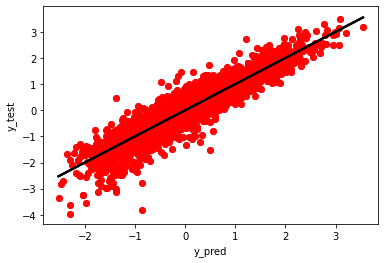

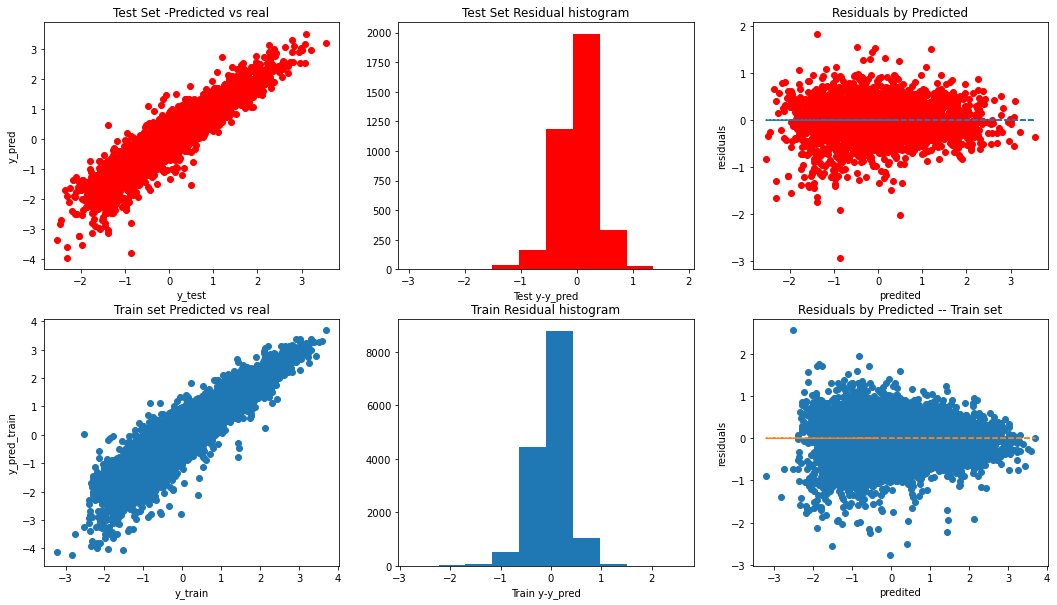

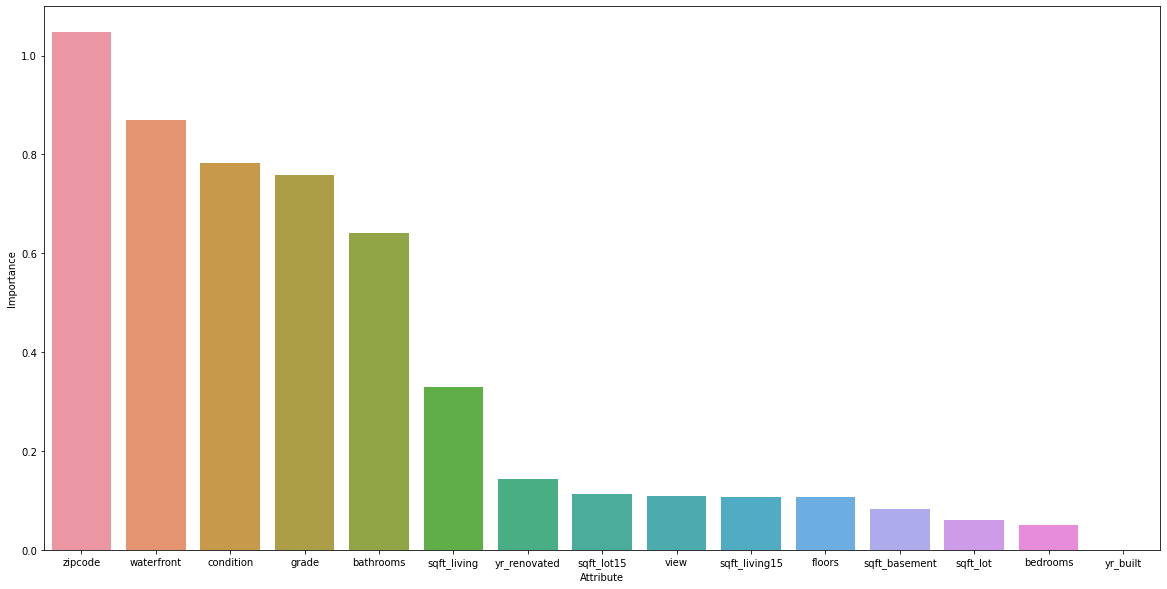

Most important features:
        Attribute  Importance
10        zipcode    1.047176
2      waterfront    0.870163
12      condition    0.783317
9           grade    0.757927
14      bathrooms    0.641557
0     sqft_living    0.329535
6    yr_renovated    0.142893
8      sqft_lot15    0.113052
3            view    0.108966
7   sqft_living15    0.107957
11         floors    0.107801
4   sqft_basement    0.083302
1        sqft_lot    0.060468
13       bedrooms    0.051049
5        yr_built    0.000458
train MSE: 0.12300543456693568 -- test MSE: 0.12602666161509957
train RMSE: 0.3507213061205944 -- test RMSE: 0.3550023402952431
train MAE: 0.12300543456693568 -- test MAE: 0.12602666161509957
r2 train: 0.8762967553982478
r2 test: 0.8766701631605832


In [171]:
validate_results(model_v4, x_train_v4, y_train_v4,y_test_v4,y_pred_train_v4, y_pred_test_v4)

<a id='final_notes'></a>
### 5. Final Notes
<a href='#content'>back to content list</a>

In [172]:


#plot_numeric(work_copy_v4)

### Discussion


The results looking straight forward

next improvements are possible to pack all zipcodes, codes, bedrooms, bathrooms and grades in groups in terms to simplify the model